# Book-Crossing Recommendation System

**Fellowship AI challenge**  
*Tom McKenzie*  
*July 2018*  

**Aim:** The aim of this project is to build a recommendation engine using the dataset(s) from **Book-Crossing**, which includes user reviews.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') # Use seaborn-style plots
plt.rcParams.update({'font.size': 20}) # Set larger default plot font size
%matplotlib inline

## Import the dataset

In [2]:
# The dataset is comprised of three separate tables: BX-Users, BX-Books, and BX-Book-Ratings.
# Each is separated by semi-colons, and the first row contains the column headers.
users = pd.read_csv('book_crossing_dataset/BX-Users.csv', sep=';')
books = pd.read_csv('book_crossing_dataset/BX-Books.csv', sep=';')
book_ratings = pd.read_csv('book_crossing_dataset/BX-Book-Ratings.csv', sep=';')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Note:** The 'BX-Books' csv had multiple cases of semi-colons in the book titles which were manually cleaned to ensure proper dataframe importing. Mostly were changed to colons or commas. Also, the symbol '&amp;' appeared a lot (presumably an ampersand character), which was changed to just '&amp'.

In [3]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [5]:
book_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(f'Users: {len(users)}\nBooks: {len(books)}\nRatings: {len(book_ratings)}')

Users: 278858
Books: 271379
Ratings: 1149780


## Investigate the 'users' dataframe

First, let's tidy up the column names.

In [7]:
users.columns = users.columns.str.strip().str.lower().str.replace('-', '_')
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [8]:
users.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [9]:
uniq_users = users.user_id.nunique()
all_users = users.user_id.count()
print(f'No. of unique user_id entries: {uniq_users} | Total user_id entries: {all_users}')

No. of unique user_id entries: 278858 | Total user_id entries: 278858


The 'User-ID' field is integers, 'Location' are strings', and the 'Age' values are floats.

We can probably change the ages to ints. Let's take a look at the values first.

In [10]:
print(sorted(users.age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

The age range goes from 0 to 244 years old! Obviously this cannot be correct; I'll set all ages less than 5 and older than 100 to NaN to try keep them realistic.

In [11]:
users.loc[(users.age<5) | (users.age>100), 'age'] = np.nan

The Ages are also currently floats - can probably change them to ints given they are whole years only.

In [12]:
users.age.fillna(0, inplace=True)
users.age = users.age.astype(int)
users.age = users.age.replace(0, np.nan) # Change zeros back to NaNs
users.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Now let's have a look at the entire age range again.

In [13]:
print(sorted(users.age.unique()))

[nan, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


Much better - now the ages go from 5 to 100, with missing values entered as NaN. Let's plot this to see how they are distributed.

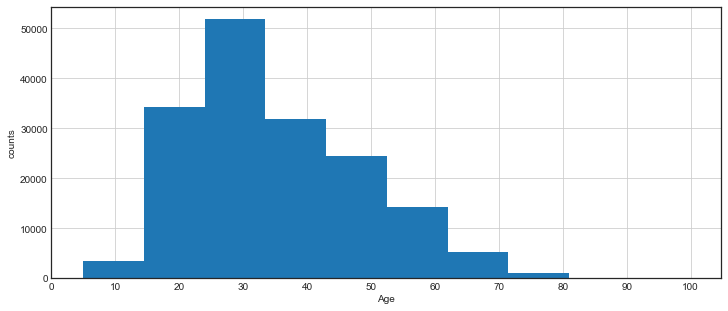

In [14]:
# First create a histogram of the Age field
ax = users.age.hist(bins=10, figsize=(12,5))
ax.set_xlabel('Age')
ax.set_ylabel('counts')
ax.set_xticks(range(0,110,10))
plt.show()

Below is the same plot without any binning - i.e. each age is represented individually.

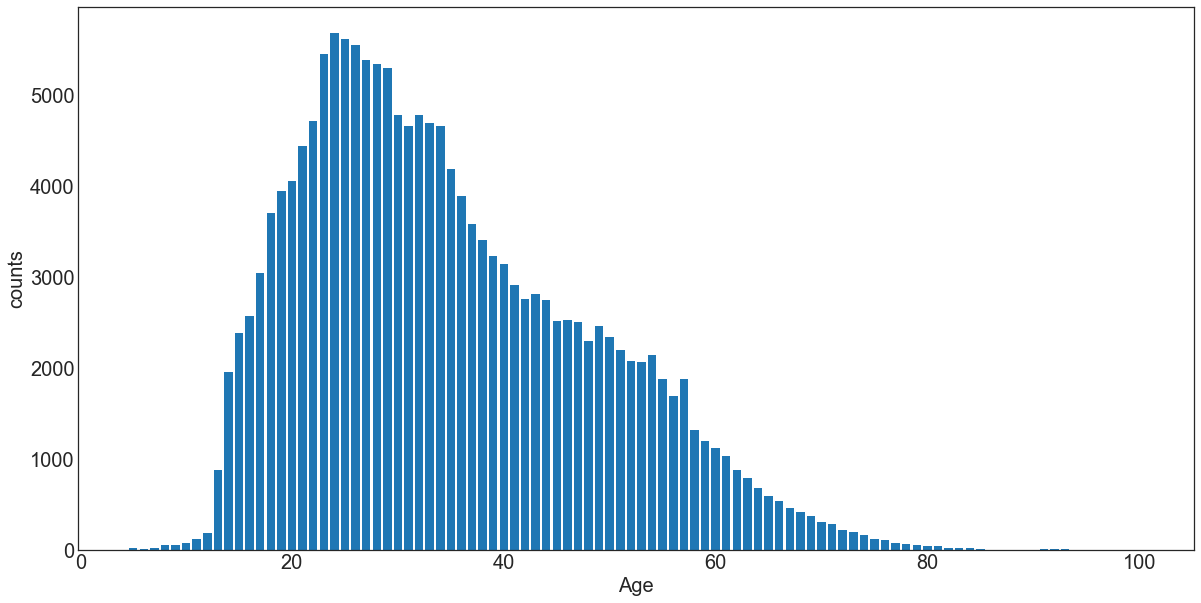

In [15]:
u = users.age.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 20}) # Set larger plot font size
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

That is more clear to me! It seems that most of our reviewers are in their late 20s to early 30s.

How many missing Age's do we now have in the dataset?

In [16]:
age_null = users.age.isnull().sum() # Sums up the 1's returned by the isnull() mask
all_users = users.user_id.count() # Counts the number of cells in the series - excludes NaNs!
print(f'There are also {age_null} empty age values in our set of {all_users} users (or {(age_null/all_users)*100:.2f}%).')

There are also 112010 empty age values in our set of 278858 users (or 40.17%).


Next, can we expand the 'Location' field to break it up into 'City', 'State', and 'Country'.

In [17]:
# Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases
user_location_expanded = users.location.str.split(',', 2, expand=True)
user_location_expanded.columns = ['city', 'state', 'country']
users = users.join(user_location_expanded)

In [18]:
users.drop(columns=['location'], inplace=True)
users.head()

,user_id,age,city,state,country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


Let's take a quick look at these Location-derived fields.

In [19]:
top_cities = users.city.value_counts()[:10]
print(f'The 10 cities with the most users are:\n{top_cities}')

The 10 cities with the most users are:
london       4105
barcelona    2664
toronto      2342
madrid       1933
sydney       1884
portland     1869
melbourne    1863
vancouver    1699
chicago      1566
seattle      1541
Name: city, dtype: int64


In [20]:
top_countries = users.country.value_counts()[:10]
print(f'The 10 countries with the most users are:\n{top_countries}')

The 10 countries with the most users are:
 usa               139183
 canada             21556
 united kingdom     18286
 germany            17021
 spain              13088
 australia          11719
 italy              11238
                     4561
 france              3440
 portugal            3305
Name: country, dtype: int64


It looks like an empty 'Country' field is in the top 10 most common entries! 

In [21]:
empty_string_country = users[users.country == ''].country.count()
nan_country = users.country.isnull().sum()
print(f'There are {empty_string_country} entries with empty strings, and {nan_country} NaN entries in the Country field')

There are 4561 entries with empty strings, and 2 NaN entries in the Country field


We should probably change these empty strings to NaNs.

In [22]:
users.country.replace('', np.nan, inplace=True)

**Might want to filter out invalid Location-based entries by looking at the city/state/country entries that only occur a few times (maybe <3), however this will be just left as is at the moment. I'll re-visit this idea more thoroughly if I end up using Location in the modeling**

## Investigate the 'books' dataframe

In [23]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


First, let's tidy up the column names. And we can probably drop the image-url link columns.

In [24]:
books.columns = books.columns.str.strip().str.lower().str.replace('-', '_') # clean column names
books.drop(columns=['image_url_s', 'image_url_m', 'image_url_l'], inplace=True) # drop image-url columns
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp Company


We want to clean up the ampersand formatting in the Publisher field.

In [25]:
books.publisher = books.publisher.str.replace('&amp', '&', regex=False)
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


In [26]:
uniq_books = books.isbn.nunique()
all_books = books.isbn.count()
print(f'No. of unique books: {uniq_books} | All book entries: {all_books}')

No. of unique books: 271379 | All book entries: 271379


Let's look at the most frequent Publishing houses in the dataset.

In [27]:
top_publishers = books.publisher.value_counts()[:10]
print(f'The 10 publishers with the most entries in the books table are:\n{top_publishers}')

The 10 publishers with the most entries in the books table are:
Harlequin                   7536
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3647
Scholastic                  3160
Simon & Schuster            2971
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: publisher, dtype: int64


What about authors with the most entries?

In [28]:
top_authors = books.book_author.value_counts()[:10]
print(f'The 10 authors with the most entries in the books table are:\n{top_authors}')

The 10 authors with the most entries in the books table are:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        373
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: book_author, dtype: int64


We should search for empty or NaN values in these fields too.

In [29]:
empty_string_publisher = books[books.publisher == ''].publisher.count()
nan_country = users.country.isnull().sum()
print(f'There are {empty_string_country} entries with empty strings, and {nan_country} NaN entries in the Country field')

There are 4561 entries with empty strings, and 4563 NaN entries in the Country field


**This looks weird... there are the same number of empty strings as were in the 'country' field of the user table...INVESTIGATE**

## Unify the 'users', 'books', and 'book_ratings' tables

In [11]:
ratings_users = book_ratings.join(users.set_index('User-ID'), on='User-ID')

In [12]:
data = ratings_users.join(books.set_index('ISBN'), on='ISBN')

In [13]:
data.tail()

,User-ID,ISBN,Book-Rating,Age,City,State,Country,Book-Title,Book-Author,Year-Of-Publication,Publisher
1149775,276704,1563526298,9,NaN,cedar park,texas,usa,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press
1149776,276706,0679447156,0,18.0,quebec,quebec,canada,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf
1149777,276709,0515107662,10,38.0,mannington,west virginia,usa,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books
1149778,276721,0590442449,10,14.0,providence,rhode island,usa,Fourth Grade Rats,Jerry Spinelli,1996,Scholastic
1149779,276723,05162443314,8,12.0,san antonio,texas,usa,NaN,NaN,NaN,NaN


## Exploratory data analysis

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 11 columns):
User-ID                1149780 non-null int64
ISBN                   1149780 non-null object
Book-Rating            1149780 non-null int64
Age                    840288 non-null float64
City                   1149780 non-null object
State                  1149780 non-null object
Country                1149780 non-null object
Book-Title             1031175 non-null object
Book-Author            1031174 non-null object
Year-Of-Publication    1031175 non-null object
Publisher              1031173 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 96.5+ MB


In [16]:
data.shape

(1149780, 11)

In [17]:
data.head()

,User-ID,ISBN,Book-Rating,Age,City,State,Country,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,NaN,tyler,texas,usa,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,NaN,seattle,washington,usa,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,16.0,h,new south wales,australia,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,16.0,rijeka,n/a,croatia,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,16.0,rijeka,n/a,croatia,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press


### Look more closely at the ISBN numbers in each of the tables

In [15]:
book_table_isbn_unique = set(books['ISBN'])
rating_table_isbn_unique = set(book_ratings['ISBN'])

In [16]:
# Find the 'symmetric difference' between these two sets - i.e. the val's that are in one but not the other!
isbn_diff = book_table_isbn_unique ^ rating_table_isbn_unique
len(isbn_diff)

71595

Ok, so is most of this difference from one of the tables?

In [17]:
in_books_but_not_in_ratings = book_table_isbn_unique - rating_table_isbn_unique
print(f'No. of books in BOOKS table not in RATINGS: {len(in_books_but_not_in_ratings)}')

in_ratings_but_not_in_books = rating_table_isbn_unique - book_table_isbn_unique
print(f'No. of books in RATINGS table not in BOOKS: {len(in_ratings_but_not_in_books)}')

No. of books in BOOKS table not in RATINGS: 1209
No. of books in RATINGS table not in BOOKS: 70386


There are far more ISBN numbers in the RATINGS table that don't appear in BOOKS.... Are these mainly typos or entry errors?

### Look at the ratings given, and how they're distributed

Text(0,0.5,'Rating')

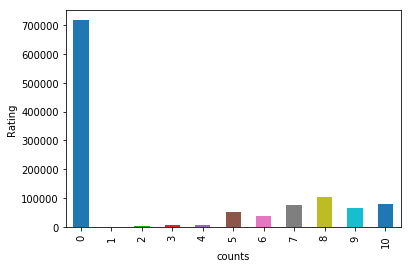

In [50]:
#data.groupby('Book-Rating')['ISBN'].count()
s = data['Book-Rating'].value_counts()
s.sort_index(inplace=True)

ax = s.plot(kind="bar")
ax.set_xlabel("counts")
ax.set_ylabel("Rating")

We can see there are **WAY** more 0 ratings given than any other value...  
I read somewhere that a '0' corresponds to an 'implicit' rating, while '1-10' was the 'explicet' rating scale.

**Proceed with 0-ratings removed from dataset**

In [43]:
data2 = data[data['Book-Rating'] > 0]

In [21]:
data2.shape

(433671, 11)

You can see that the dataset size has shrunk from ca. 1.15 million rows to 433 thousand - i.e. the ca. 700 thousand zero-rated entries have been removed.

### Data overview

In [22]:
tot_users = data2['User-ID'].nunique()
tot_books = data2['ISBN'].nunique()

print(f'Unique users: {tot_users} | Unique books: {tot_books}')

Unique users: 77805 | Unique books: 185973


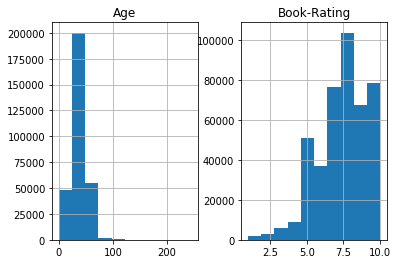

In [23]:
hist = data2[['Age', 'Book-Rating']].hist()

**Look at the ages entered**

In [24]:
print(sorted(data2.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 103.0, 104.0, 105.0, 108.0, 109.0, 114.0, 116.0, 118.0, 124.0, 128.0, 132.0, 133.0, 136.0, 138.0, 140.0, 141.0, 146.0, 147.0, 148.0, 151.0, 152.0, 172.0, 199.0, 200.0, 201.0, 204.0, 209.0, 212.0, 219.0, 220.0, 223.0, 226.0, 228.0, 229.0, 237.0, 239.0, 244.0]


**The ISBN entries are strings - convert to numeric vals**

In [48]:
# Convert ISBN entries to floats (can't convert to ints as there is no NaN support for ints in Pandas)
data2['ISBN'] = pd.to_numeric(data2['ISBN'], errors='coerce')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
data2['ISBN'].isnull().sum()

36342

There are 36,342 missing ISBN entries in our dataset.

Can we clean this by linking other entries of the same Title/Author/Year and grabbing the ISBN associated with *that* entry???

### Let's plot our ratings again to see how it looks

Text(0,0.5,'Rating')

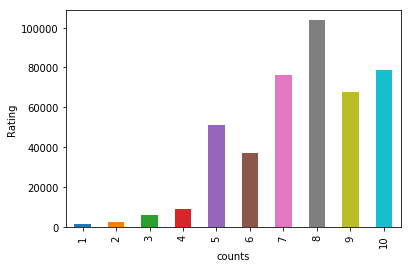

In [51]:
s = data2['Book-Rating'].value_counts()
s.sort_index(inplace=True)

ax = s.plot(kind="bar")
ax.set_xlabel("counts")
ax.set_ylabel("Rating")

It seems that ratings less than 5 occur very infrequently, while 8 is the most common user rating given!

# Collaborative Filtering method

Initially, I'll remove all of the other fields except 'User-ID', 'ISBN', and 'Book-Rating' as those are all we need for a basic collaborative filtering model.

In [32]:
data3 = data2[['User-ID', 'ISBN', 'Book-Rating']] # select only user, book, and rating columns
data3.columns = ['userID', 'bookID', 'rating'] # simplify column names
data3.head()

,userID,bookID,rating
1,276726,1.550612e+08,5
3,276729,NaN,3
4,276729,5.217950e+08,6
6,276736,3.257224e+09,8
7,276737,6.005710e+08,6


_**Note**_: ISBN numbers are currently 13 digits long, but used to be 10. Any ISBN that isn't 10 or 13 digits long is probably an error that should be handled somehow. Any that are 9 digits long might actually be SBN numbers (pre-1970), and can be converted into ISBN's by just pre-fixing with a zero.

Different ISBN's are assigned to different formats of the same book; for example, an e-book, paperback, or hardcover or Pride & Prejudice would each have a different ISBN.

The ISBN number is actually encoded info about the 'group', 'title', and 'publisher'... but not sure if I need to extract that info for this project.

# Using sklearn

In [32]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(data3, test_size=0.25)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
test_data.head()

,User-ID,ISBN,Book-Rating
158487,35859,380717581.0,7
754067,182403,684195305.0,8
984958,236655,330412264.0,8
1003599,240906,399138412.0,8
570604,137007,NaN,9


Need to cast the ISBN to int type for the matrix-forming step below. As int doesn't have NaN's, we'll convert them to zeros, then filter out any rows with an ISBN of zero.

In [37]:
test_data['book'] = test_data['book'].fillna(0.0).astype(int)

# If we're doing this we could just use dropna() instead
# test_data['book'] = test_data['book'].dropna().astype(int)

test_data = test_data[test_data['book'] > 0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
test_data.dtypes

user      int64
book      int64
rating    int64
dtype: object

### Assign each unique 'User-ID' or 'ISBN' an int value starting from 1 that can be mapped back

In [39]:
# Get int mapping for USER
u_unique = test_data.user.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_user2idx = {o:i for i, o in enumerate(u_unique)}

# Get int mapping for ISBN
b_unique = test_data.book.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_book2idx = {o:i for i, o in enumerate(b_unique)}

In [40]:
test_data['u_unique'] = test_data['user'].map(test_data_user2idx)
test_data['b_unique'] = test_data['book'].map(test_data_book2idx)

test_data = test_data[['u_unique', 'b_unique', 'rating']]

### Memory-based collaborative filtering

Implementing via this [tutorial](https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html).

Memory based CF can be divided into 2 main approaches:
 - Item-Item CF: "Users who liked this item also liked..."
 - User-Item CF: "Users who are similar to you also liked..."
 
In both cases, you create a user-item matrix built from the entire dataset. We'll create a matrix for each of the training and testing sets, with the users as the rows, the books as the columns, and the rating as the value/entry. Note that this will be a very sparse matrix, as not every user will have watched every movie etc.

In [41]:
# Create user-item matrices
n_users = test_data['u_unique'].nunique()
n_books = test_data['b_unique'].nunique()

# First, create an empty matrix of size USERS x BOOKS (this speeds up the later steps)
test_matrix = np.zeros((n_users, n_books))
# Then, add the appropriate vals to the matrix by extracting them from the df with itertuples
for entry in test_data.itertuples():
    test_matrix[entry[1], entry[2]] = entry[3] # entry[1] is the user-id, entry[2] is the book-isbn

Now the matrix is in the correct format, with the user and book entries encoded from the mapping dict created above!

### Calculating cosine similarity with the 'pairwise distances' function

To determine the similarity between users/items we'll use the 'cosine similarity' which is a common n-dimensional distance metric.

Note: since all of the rating values are positive (1-10 scale), the cosine distances will all fall between 0 and 1.

In [44]:
test_matrix.shape

(32005, 60594)

In [45]:
# This crashed the kernel last time
test_matrix_small = test_matrix[:10, :10]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(test_matrix_small, metric='cosine')
item_similarity = pairwise_distances(test_matrix_small.T, metric='cosine') # .T transposes the matrix (NumPy)

# What about tring 'cosine_similarity'?
# from sklearn.metrics.pairwise import cosine_similarity

If we are looking at similarity between users we need to account for the average behaviour of that individual user. For example, one user may give all movies quite high ratings, whereas one might give all ratings between 3 and 7. These users might otherwise have quite similar preferences.

To do this, we use the users average rating as a 'weighting' factor.

If we are looking at item-based similarity we don't need to add this weighting factor.

We can incorporate this into a ```predict()``` function, like so:

In [46]:
def predict(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Then can make our predictions!

In [47]:
item_prediction = predict(test_matrix_small, item_similarity, type='item')
user_prediction = predict(test_matrix_small, user_similarity, type='user')

### Evaluation

How are we going to know if this is a good model?

We'll start by just taking the root mean squared error (RMSE) (from sklearn) of predicted values in the test_set (i.e. where we know what the answer should be!).

Since we want to compare only predicted ratings that are in the test set, we can filter out all other predictions with ```prediction[ground_truth.nonzero()]```.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

# Call on test set to get error from each approach ('user' or 'item')
print(f'User-based CF RMSE: {rmse(user_prediction, test_data_matrix)}')
print(f'Item-based CF RMSE: {rmse(item_prediction, test_data_matrix)}')

Although memory-based CF is simple to implement, they don't scale very well! (Hence why some of these steps were so computationally expensive). Moreover, they fail to address the classic 'cold-start problem' - i.e. to provide recommendations to a new user with no review/rating history. 

Conversly, model-based CF methods are scalable and can deal with higher sparsity level than memory-based models. However, they still suffer for new users ('cold-start').

## Model-based CF
Model-based CF is largely based on 'matrix factorization'. 

# Using 'surprise' library
There is a python library built especially to help build recommender systems called ```surprise```.  
It includes several common model-based algorithms including SVD, KNN, and non-negative matrix factorization!  
See [here](http://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage) for details.

In [33]:
from surprise import Reader, Dataset

In [34]:
# First need to create a 'Reader' object to set the scale/limit of the ratings field
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'Dataset' object directly from the pandas df.
# Note: The fields must be in the order: user, item, rating
data = Dataset.load_from_df(data3[['userID', 'bookID', 'rating']], reader)

In [35]:
# Load the models and 'evaluation' method
from surprise import SVD, NMF, model_selection, accuracy

Note: SVD = Singular Value Decomposition (orthogonal factorization), NMF = Non-negative Matrix Factorization.

## SVD model

**_Using cross-validation_**

In [41]:
# svd
model = SVD()

# Run 5-fold cross-validation and print results.
# Note: Might want to try using a train/test split instead of cv and see if there is much difference.
model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True) # use Root Mean Squared Error as metric

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6397  1.6367  1.6418  1.6489  1.6501  1.6434  0.0052  
MAE (testset)     1.2665  1.2664  1.2700  1.2725  1.2721  1.2695  0.0026  
Fit time          30.45   30.70   31.21   30.74   30.84   30.78   0.25    
Test time         33.44   32.69   33.35   33.17   33.37   33.21   0.27    


{'fit_time': (30.44518208503723,
  30.695334911346436,
  31.20512580871582,
  30.73613214492798,
  30.83859610557556),
 'test_mae': array([1.26651424, 1.26643807, 1.27001941, 1.2725315 , 1.27205919]),
 'test_rmse': array([1.63965345, 1.63669436, 1.64181506, 1.64889969, 1.65013312]),
 'test_time': (33.439846992492676,
  32.69018602371216,
  33.35129904747009,
  33.172361850738525,
  33.37319016456604)}

The SVD model gave a Mean RMSE of 1.6434 after 5-folds, with a fit time of ca. 30 s.

**_Using test-train split_**

In [37]:
# set test set to 25%.
trainset, testset = model_selection.train_test_split(data, test_size=.25)

# Instantiate the SVD model.
model = SVD()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.6402


1.640165859393621

The SVD model using a 75% train-test split gave a RMSE of 1.64017.

### NMF model

In [42]:
# nmf
model = NMF()
# Run 5-fold cross-validation and print results.
model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.3928  2.4038  2.4104  2.4127  2.4167  2.4073  0.0084  
Fit time          61.09   61.10   61.62   61.20   61.11   61.22   0.20    
Test time         35.61   35.78   35.39   35.27   35.75   35.56   0.20    


{'fit_time': (61.08832097053528,
  61.09781193733215,
  61.62235975265503,
  61.19665598869324,
  61.10865592956543),
 'test_rmse': array([2.39279397, 2.4037592 , 2.41035003, 2.41267996, 2.41666811]),
 'test_time': (35.61138200759888,
  35.777597188949585,
  35.39391899108887,
  35.269122838974,
  35.74649691581726)}

The NMF model gave a mean RMSE of 2.4073, with a fit time of ca. 60 s. This is much worse than the SVD model.